In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [8]:
class Dense_Layer(tf.keras.layers.Layer):
    """DenseLayer represents a Layer in our Network, inherits from keras.layer.Layer."""
    
    
    def __init__(self, units=256, activation=tf.nn.sigmoid):
        """
        Constructor, calls super Constructor, initializes layer with 256 units and activation function sigmoid.
        ## Params
            - units = units in hidden layer (standard=256)
            - activation = activation function (standard=sigmoid)
        """
        super(Dense_Layer, self).__init__()
        self.units = units
        self.activation = activation
    
    
    def build(self, input_shape): 
        """
        Sets the weights of our network to random, sets an input shape and makes weights trainable.
        ## Params
            - input_shape = input shape for network
        """
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
  

    def call(self, inputs):
        """
        Update weights/biases of each neuron
        ## Params
            - inputs = inputs for neurons
        """
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x
    
class MyModel(tf.keras.Model):
    """MyModel represents a Tensorflow Model, inherits from keras.Model."""
    
    
    def __init__(self):
        """Constructor, calls super Constructor, initializes 2 hidden layers and an output layer."""
        super(MyModel, self).__init__()
        self.hidden1 = Dense_Layer(5) # We only need 20 neurons
        self.hidden2 = Dense_Layer(5)
        self.out = Dense_Layer(1) # Output layer uses sigmoid as well

        
    @tf.function
    def call(self, inputs):
        """
        Update weights/biases of each layer (calls call of each neuron).
        ## Params
            - inputs = inputs for network
        """
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [3]:
def train_step(model, input, target, loss_function, optimizer):
    """
    Function for model training
    ## Params
        - model = instance of MyModel class
        - input = input for model 
        - target = targets
        - loss_function = loss function
        - optimizer = tensorflow optimizer
    """
    with tf.GradientTape() as tape:
        prediction = model(input) # Make binary to enable target-comparison tf.map_fn(lambda x: 1. if x > 0.5 else 0., model(input))
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    """
    Function for model testing 
    ## Params
        - model = instance of MyModel class
        - test_data = data for testing
        - loss_function = loss function
    """
    # we use numpy array here to speed things up
    test_accuracy_aggregator = np.empty(0)
    test_loss_aggregator = np.empty(0)

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = target == np.round(prediction,0)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator = np.append(test_loss_aggregator, sample_test_loss.numpy())
        test_accuracy_aggregator = np.append(test_accuracy_aggregator, np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [4]:
def make_binary(target, median):
    if target > median:
        return tf.constant(1, dtype=tf.float64)
    return tf.constant(0, dtype=tf.float64)

In [5]:
def preprocessing_pipeline(ds, split_fracs = (0.7,0.15,0.15), batch_size = 8, prefetch_size = tf.data.AUTOTUNE, normalize = False):

    # compute target median
    target_median = np.median( ds.loc[ :, "quality" ]) 

    # For optional normalization
    max_vals = ds.max()
    min_vals = ds.min()

    # split the dataset
    train_ds =      ds.sample(frac=split_fracs[0], replace = False) # disallow rows to be sampled multiple times
    validation_ds = ds.sample(frac=split_fracs[1], replace = False)
    test_ds =       ds.sample(frac=split_fracs[2], replace = False)

    # separate values and targets
    train_vals, train_targets =             ( train_ds.drop(        columns="quality" ).values, train_ds.loc[ :, 'quality' ].values )
    validation_vals, validation_targets =   ( validation_ds.drop(   columns="quality" ).values, validation_ds.loc[ :, 'quality' ].values )
    test_vals, test_targets =               ( test_ds.drop(         columns="quality" ).values, test_ds.loc[ :, 'quality' ].values )

    # create TF datasets
    train_ds = tf.data.Dataset.from_tensor_slices(      ( train_vals, train_targets ) )
    validation_ds = tf.data.Dataset.from_tensor_slices( ( validation_vals, validation_targets ) )
    test_ds = tf.data.Dataset.from_tensor_slices(       ( test_vals, test_targets ) )

    # Make targets binary
    if normalize == False:
        train_ds = train_ds.map(            lambda val, target: (val, make_binary(target, target_median)) )
        validation_ds = validation_ds.map(  lambda val, target: (val, make_binary(target, target_median)) )
        test_ds = test_ds.map(              lambda val, target: (val, make_binary(target, target_median)) )
    else: # Also normalize values if param is set true
        train_ds = train_ds.map(            lambda val, target: ( ( val - min_vals ) * 2 / max_vals - 1, make_binary(target, target_median) ) )
        validation_ds = validation_ds.map(  lambda val, target: ( ( val - min_vals ) * 2 / max_vals - 1, make_binary(target, target_median) ) )
        test_ds = test_ds.map(              lambda val, target: ( ( val - min_vals ) * 2 / max_vals - 1, make_binary(target, target_median) ) )

    # Batch and Prefetch the splits
    train_ds =      train_ds.batch( batch_size ).prefetch( prefetch_size )
    validation_ds = validation_ds.batch( batch_size ).prefetch( prefetch_size )
    test_ds =       test_ds.batch( batch_size ).prefetch( prefetch_size )

    return train_ds, validation_ds, test_ds

In [9]:
tf.keras.backend.clear_session()

# Load DS
data_set=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=";")

# Preprocess
train_ds, validation_ds, test_ds = preprocessing_pipeline(data_set)

# define hyperparams
learning_rate = tf.constant(0.1, dtype=tf.float64)
num_epochs = 10
model = MyModel()
loss_func = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate)

# arrays for later visualization
# we use numpy arrays in order to speed things up
train_losses = np.empty(0)
validation_losses = np.empty(0)
validation_accuracies = np.empty(0)
test_losses = np.empty(0)
test_accuracies = np.empty(0)

# initial test before training
validation_loss, validation_acc = test(model, validation_ds, loss_func)
validation_losses = np.append(validation_losses, validation_loss)
validation_accuracies = np.append(validation_accuracies, validation_acc)

# model performance before training
train_loss, _ = test(model, train_ds, loss_func)
train_losses = np.append(train_losses, train_loss)

# training of our model
for epoch in range(num_epochs):
    print(f'Epoch {str(epoch)} starting with accuracy {validation_accuracies[-1]}')

    epoch_loss_agg = np.empty(0)
    for input, target in train_ds:
        train_loss = train_step(model, input, target, loss_func, optimizer)
        epoch_loss_agg = np.append(epoch_loss_agg, train_loss)

    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))

    validation_loss, validation_acc = test(model, validation_ds, loss_func)
    validation_losses = np.append(validation_losses, validation_loss)
    validation_accuracies = np.append(validation_accuracies, validation_acc)

Epoch 0 starting with accuracy 0.14583333333333334
Epoch 1 starting with accuracy 0.8541666666666666
Epoch 2 starting with accuracy 0.8541666666666666
Epoch 3 starting with accuracy 0.8541666666666666
Epoch 4 starting with accuracy 0.8541666666666666
Epoch 5 starting with accuracy 0.8541666666666666
Epoch 6 starting with accuracy 0.8541666666666666
Epoch 7 starting with accuracy 0.8541666666666666
Epoch 8 starting with accuracy 0.8541666666666666
Epoch 9 starting with accuracy 0.8541666666666666


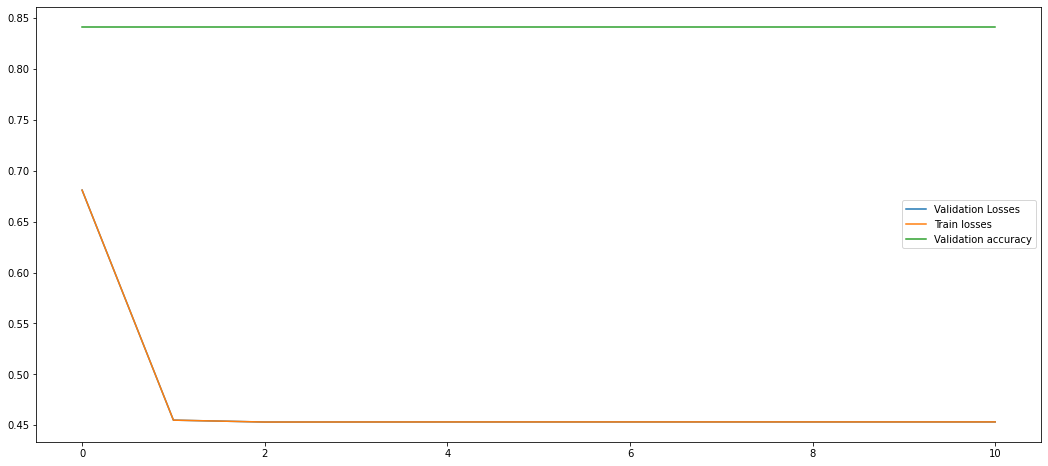

In [7]:
plt.figure(figsize=(18,8))
plt.plot(range(num_epochs+1),validation_losses,label="Validation Losses")
plt.plot(range(num_epochs+1),validation_losses, label="Train losses")
plt.plot(range(num_epochs+1),validation_accuracies, label = "Validation accuracy")
plt.legend()
plt.show()